In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, log
from random import sample
from tqdm import tqdm
sns.set()

In [141]:
#import kaggle data set

data = pd.read_csv('/Users/vishesh.javangula@ibm.com/Downloads/train.csv')

## Datset Details

Through our visualizations I can see how the images resemble handwriting rather than digital fonts. As a result I expect some error in our predictions due to the variances in human handwriting. Furthermore the footprint of the actual written number on the 28x28 canvas vary in size. This will infleunce my features selection process, or lack thereof, due to needing all 28^2 pixels. In terms of balance, I noted that we have significanlty fewer labels for digit '5' than others. Also, due to the time compleity of random forest, I decided to only sample 100 images for each label. 

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


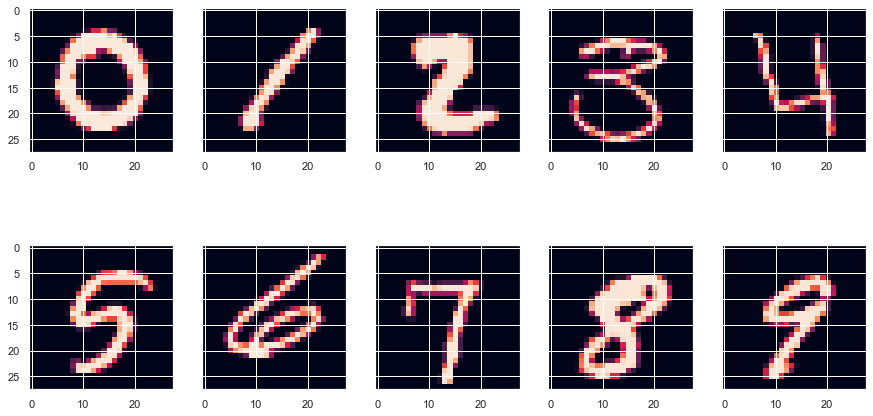

In [142]:
#Visualization
from PIL import Image as im
fig, ax = plt.subplots(2,5, figsize=(15,8), sharey=True)
grouped_images = data.groupby(['label'])

for j, group in enumerate(grouped_images):
    labels, values = group
    values.drop(columns=['label'], inplace=True)
    num = values.iloc[0].to_numpy()
    num = np.reshape(num,(28,28)) #converts to correct dimensions
    ax[int(j/5)][j % 5].imshow(num)

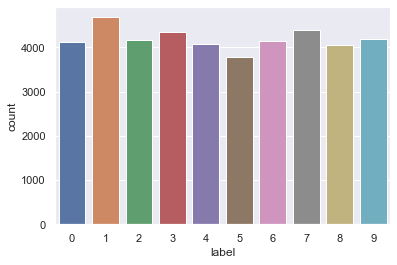

In [143]:
#How balanced is my dataset?
ax = sns.countplot(x='label', data=data)

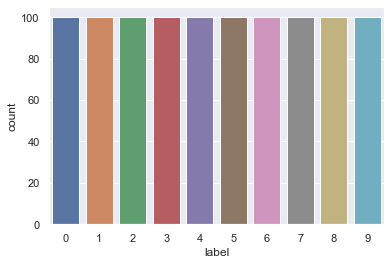

In [201]:
data.drop_duplicates(inplace=True)
#subset of data
sub_data = pd.DataFrame()
for label, group in data.groupby(by='label'):
        sub_data = pd.concat([sub_data,group.sample(n=100)])
ax = sns.countplot(x='label', data=sub_data)


### Algorithm Description

As mentioned earlier, Random Forest is a slow algorithm to train. I therefore used 100 samples from each label to make up the training data. I also dropped any duplicates and dropped any columns who only consisted of a single value. This is because having a column with a single value for all images cannot help seperate our labels. This also serves as a form of dimensionality reduction, which is needed due to the time needed for each decision tree to test thresholds for some m features for each attempted split. In terms of hyperparameter, the literature states that the optimal number of sampled features is either sqrt(N) or log2(N+1). For this experiment, I decided to go with sqrt(N). By default early stopping and cleaving is turned off in other implementations of random forest. I decided mimic this and set the max depth to be 650, which would only become relevant if each split only seperated 1-2 rows at a time. In terms of the number of trees, the literature states that somewhere between 64 and 128. I chose 100 since it's somewhere in the middle. Finally, I decided to use majority votes to determine the classification since taking the average may yield a non-integer value. 

In [202]:
#remove rows whose only valus is 0, this is a form of dimensionality reduction 
for label, series in data.iteritems():
    if(series.nunique() == 1):
        sub_data.drop(columns=label, inplace=True)
sub_data.reset_index(inplace=True, drop=True)
        

In [203]:
sub_data.shape

(1000, 709)

In [204]:
sub_data.head()

,label,pixel12,pixel13,pixel14,pixel15,pixel32,pixel33,pixel34,pixel35,pixel36,...,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Random Forest

In [169]:



#Need information Gain

def entropy(groups):
    #get total number of instances
    total = sum([len(group) for group in groups])
    #print('total size data is {}'.format(total))
    
    e_total = 0
    for group in groups:
        group_size = len(group)
        
        if(group_size == 0):
            continue
            
        e_group = 0 #entropy for a specific group
        for label, group_data in group.groupby(by='label'):
            p = len(group_data)/group_size
            e_group += -1 * p * log(p,2)
        e_total += (group_size/total)*e_group
       # print('group_size: {}, e_group: {}'.format(group_size, e_group))
    return e_total

def test_split(feature, threshold, data):
    left = data[data[feature] <= threshold]
    right = data[data[feature] > threshold]
    return left, right

#takes in parent data and finds best split
## returns node that holds with it entropy, its corresponding dataset, feature, and threshold for that feature
def get_split(data, p_entropy):
    
    entropies = []
    b_split = {'feature': 0, 'threshold':0, 'entropy':9999, 'groups':0} # intial split has maximum entropy
    for label, series in data.iloc[:,1:].iteritems():
        series_sort =  np.sort(data[label].unique())
        for i in range(0,len(series_sort),2): #iterate by two to have the threshold be the mean of every pair
            threshold = np.mean([series_sort[i:i+2]])
           # print('threshold values: {}'.format(threshold))
            groups = test_split(label,  threshold , data)
            e = entropy(groups)
            if(e < b_split['entropy']):
                b_split = {'feature': label, 'threshold': threshold, 'entropy':e, 'groups':groups}
                
    #if informaiton gain is positve, we make a terminal node, else we return a regular node
    
    #print('p_entropy: {}, b_split[entropy]: {}'.format(p_entropy, b_split['entropy']))
    if(p_entropy <= b_split['entropy'] ):
        return terminal(data)
    else:
        return b_split

#returns the class value for a group of rows
def terminal(group):
    #print('setting terminal node to: {}'.format(int(group.groupby(by='label').count()['pixel400'].idxmax())))
    return int(group.groupby(by='label').count().iloc[:,2].idxmax())
    
#leverages current node's groups to create child nodes
def split(node, max_depth, curr_depth):
    
    left, right = node['groups']
    
    #check if length of nodes is 1, if so make a terminal nodes
    if(left.empty or right.empty):
        node['left'] = terminal(pd.concat(list(node['groups'])))
        node['right'] =  node['left']
        return
    
    if(curr_depth >= max_depth):
        node['left'] = terminal(left)
        node['right'] = terminal(right)
        return
    
    #create left hand size
    node['left'] = get_split(left, node['entropy'])
    
    #if information gain was negative, we can continue forming child nodes
    if(not(isinstance(node['left'],int))):
        split(node['left'], max_depth, curr_depth+1)
    
    #create right hand size
    node['right'] = get_split(right, node['entropy'])
    if(not(isinstance(node['right'],int))):
        split(node['right'], max_depth, curr_depth+1)
    
def get_tree(num_features, x_train, max_depth):
    
    #select subset of features
    x_train = x_train[['label'] + sample(list(x_train.iloc[:,1:].columns), num_features)]
   
    
    #get entropy of starting dataset 
    p_entropy = entropy((pd.DataFrame(), x_train))
   
    #create tree based off of those features
    root = get_split(x_train, p_entropy) #returns perfect split
    split(root, max_depth, 1)
    
    return root

def predict(node, row):
    
    #determine whether to look left 
    if(row[node['feature']] <= node['threshold']):
        #if current node's left is a dictionary, then move there
        if isinstance(node['left'], int):
            return node['left']
        else:
            return predict(node['left'], row)
        #else return the value in the left child
    if(row[node['feature']] > node['threshold']):
        if isinstance(node['right'],int):
            return node['right']
        else:
            return predict(node['right'],row)
    
    
    #determine whether to look right

#def bag_error(root, x_test, y_test):
   # y_pred = [predict(root, row) for _, row in  x_test.iterrows()]
    
    
    
    
    
    
    
    

    

In [183]:
def avg_votes(votes, size):
    y_pred = np.zeros(size)
    for i,arr in enumerate(votes):
        y_pred[i] = np.argmax(arr) #majority
    return y_pred
        

In [278]:
# Generate bootstrap sample to form your training data



def train_test_split(data):
    
    #assign probabilities to each row
    weights_arr = [1-pow(1-(1/data.shape[0]),data.shape[0]) for i in range(data.shape[0])]
    weights = pd.Series(data = weights_arr)
    
    train = data.sample(n=700, weights=weights_arr, replace=True)
    test = data.merge(train.drop_duplicates(), how='left', indicator=True)
    test = test[test['_merge'] == 'left_only']

    test_label = test['label']
    test.drop(columns=['_merge','label'], inplace=True)
    
    return(train, test, test_label)


#Use that sample and random subset of features to build tree

def random_forest(num_trees, num_features, max_depth,data):
    data.reset_index(inplace=True, drop=True)
    
    votes = np.zeros((data.shape[0], 10))
    
    model = [0 for i in range(num_trees)]
    
    for i in range(num_trees):
        x_train, x_test, y_test = train_test_split(data)
        #x_test.reset_index(inplace=True, drop=True)
        model[i] = get_tree(num_features, x_train, max_depth)
        for index, series in x_test.iterrows():
            votes[index][predict(model[i], series)] += 1
    
    return model, avg_votes(votes, data.shape[0]) # we still need to return the model and use it for hyperparameter tuning

#Calculate out-of-bag error for that tree, store that trees vote for later
def error(y_test, y_pred):
    results = np.zeros((10,10))
    y_test = y_test.to_numpy()
    for index,pred in enumerate(y_pred.astype(int, copy=False)):
        if y_test[index] == pred:
            
            results[pred][pred] += 1
        else:
            results[y_test[index]][pred] += 1
    return sns.heatmap(data=results.astype(int, copy=False), annot=True, fmt="d")

### Algorithm Result

The model did reasonably well for the first few digits. Performance dipped significantly for digit 5 and digit 8. The model incorrectly guessed 3 the most when the digit was actually 5. This is not too surprising since 3 easily look like 5 if we removed the sharp corners. The model also confused the number 8 with 1, something that the KNN model also did. I expected the variance in the models to result in better performance than KNN, but based off of the decision matirx, KNN performed better overall. This may be because the data size for KNN was much larger (500 per label). The limitied number of samples used in training random forest may have resulted in trees failing to address the variances within each digit. Alternatively, the hyperparameters may not be ideal for this project and with hyperparameter tuning, it's possible that performance may increase and surpass KNN.


<AxesSubplot:>

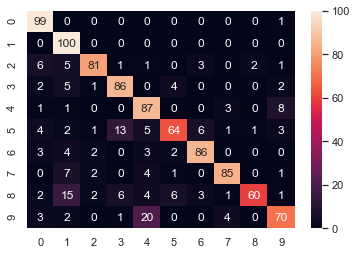

In [279]:
model, y_pred = random_forest(100,28,650,sub_data)
error(sub_data['label'], y_pred)


### Sources

handling continous values for decision trees --> https://arxiv.org/pdf/cs/9603103.pdf
How many features should I sample? --> https://datascience.stackexchange.com/questions/23666/how-many-features-to-sample-using-random-forests
How many trees? --> https://www.researchgate.net/publication/230766603_How_Many_Trees_in_a_Random_Forest

### Time Complexity 

Since we have continous integer values, we are sorting them and using the mean of every pair. This dominates the run time for each split, which is O(m*nlogn) where m is the number of features and n is the size of the data. We then do this multiple times per tree for 100 trees. Our result will around 100*m*nlogn. In our case we have 709 features and 1000 rows, we therefore coluld reprsent the runtime as 0.7n*nlogn, which turns out to be 0.7n^2*log(n). When compared to KNN, which is O(n^2), it seems that random forest is only faster when n >> m. as n approaches m, random forest becomes a slower algorithm that KNN. 

